In [63]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Define global values for the model

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 25
CHANNELS = 3
EPOCHS = 50

### Create batches of data from the Grapevine leaves dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("Grape_types", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 500 files belonging to 5 classes.


#### Check if the classes have been correctly identified

In [4]:
class_names = dataset.class_names
class_names

['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

#### Check the format of the input

In [5]:

for image_batch in dataset.take(1):
    print(image_batch[0].shape)

(25, 256, 256, 3)


### Split the dataset into **Training**, **Validation** and **Testing** data.

#### Create a costume function for the splitting

In [6]:
def get_tf_dataset_partition(dataset, train_split=0.7, test_split=0.2, val_split=0.1, shuffle=True):
    """Splits a data set into three different ones based on the given proportions.
    
    The total sum of the split args must be 1.

    Args:
        dataset - Expects a tensorflow.python.data.ops.prefetch_op._PrefetchDataset object.
        train_split - percentage of training data to be extracted, expects a numer between 0 and 1
        test_split - percentage of testing data to be extracted, expects a numer between 0 and 1
        val_split - percentage of validation data to be extracted, expects a numer between 0 and 1
        shuffle - True by default, enables the shuffling of the dataset before splitting it

    Returns:
        List containing the 3 data sets: Training, Testing and Validation
    """
    #Avoid rounding erros and float reconversion
    assert 0.9999 <(train_split + test_split + val_split) <= 1 ,"Data split is not matching the proportions"
    dataset_size = len(dataset)

    if shuffle:
        dataset= dataset.shuffle(buffer_size=dataset.cardinality())
    
    train_size = int(dataset_size * train_split)
    test_size = int(dataset_size * test_split)
    val_size = int(dataset_size * val_split)

    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).take(test_size)
    val_ds = dataset.skip(train_size + test_size).take(val_size)
    

    return train_ds, test_ds, val_ds

#### Split the dataset and check the proportions

In [7]:
train_ds, val_ds, test_ds = get_tf_dataset_partition(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

14
4
2


#### Cache, Shuffle, and Prefetch the Dataset for a more efficient training process

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Create Layers for Keras Sequential

#### Resizing and Normalization layer

In order to improve the model's performance, the images wil be resized to 256x256 and we normalize the pixel value.

In [9]:
resize_and_rescale = tf.keras.Sequential()
resize_and_rescale.add(keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE))
resize_and_rescale.add(keras.layers.Rescaling(1.0/255))

#### Data Augmentation layer
This layer can boost the accuracy of the model when we don't have a large sample size.

In [10]:
data_augmentation = tf.keras.Sequential()
data_augmentation.add(keras.layers.RandomFlip("horizontal_and_vertical"))
data_augmentation.add(keras.layers.RandomRotation(0.2))

#### Adding all the layerns to the CNN
After multiple tryouts, I've came up with this layer setup to get a high accuracy for the model.

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = keras.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

model.build(input_shape=input_shape)

In [40]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (25, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (25, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (25, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (25, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (25, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (25, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (25, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (25, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (25, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (25, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (25, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (25, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (25, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (25, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (25, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (25, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (25, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (25, 5)                     │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [41]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [45]:
history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8814 - loss: 0.3204 - val_accuracy: 0.9300 - val_loss: 0.3896
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8920 - loss: 0.2966 - val_accuracy: 0.8400 - val_loss: 0.5522
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9055 - loss: 0.2671 - val_accuracy: 0.9500 - val_loss: 0.3804
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9030 - loss: 0.3380 - val_accuracy: 0.9300 - val_loss: 0.4409
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9206 - loss: 0.2376 - val_accuracy: 0.9300 - val_loss: 0.3980
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9233 - loss: 0.2144 - val_accuracy: 0.9000 - val_loss: 0.4445
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9002 - loss: 0.2518 - val_accuracy: 0.8400 - val_loss: 0.6212
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8832 - loss: 0.3336 - val_accuracy: 0.

### Check the model performance

#### Performance based on the training set

In [46]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9333 - loss: 0.2667


[0.23916399478912354, 0.9399999976158142]

### Run prediction on a sample image

In [61]:
import numpy as np

def predict(model, data):
    #transform the given images to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(data[i].numpy())
    #add another dimension in case we serve a single image to the function
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    #extract the highest probability from the prediction and use the index to get the corresponding class
    predicted_class = class_names[np.argmax(predictions[0])]
    #calculate the confidence based on the prediction score and round it up
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


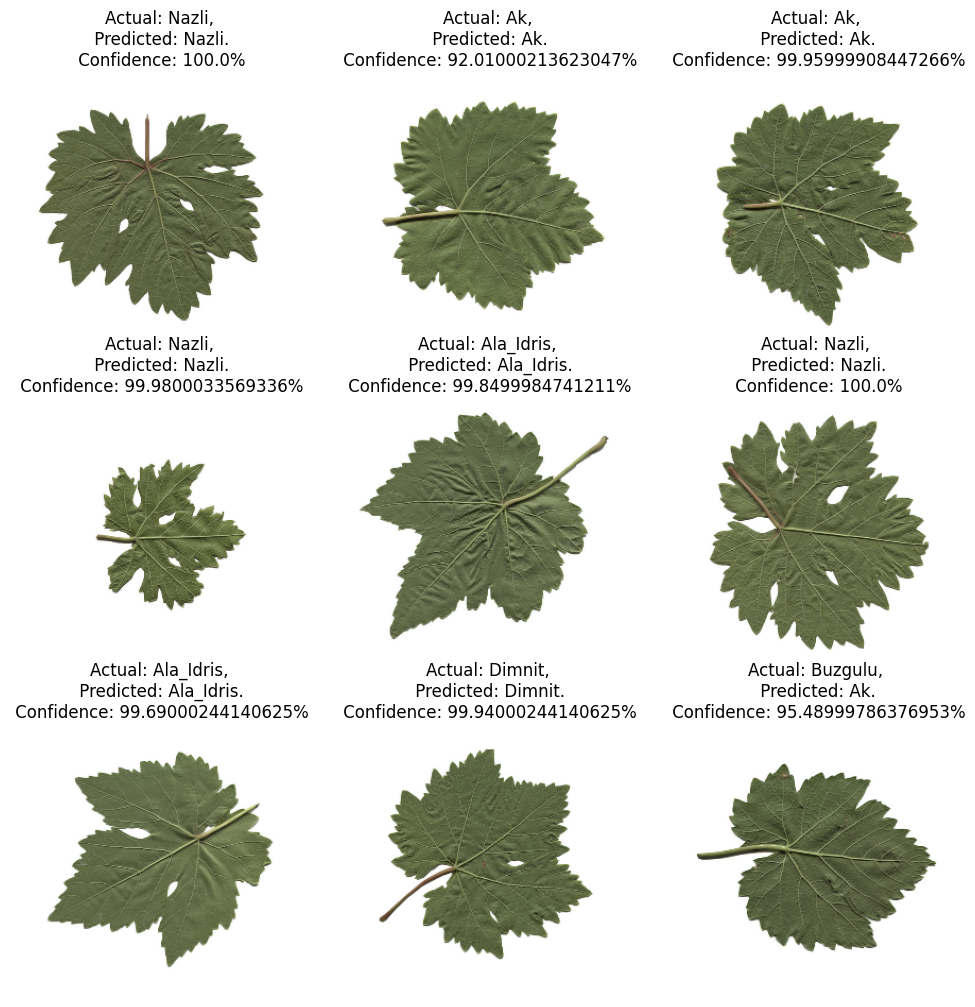

In [62]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")